In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import lightgbm as lgbm

### Levanto los datos , en este caso sin preprocesar y hago el mimino preproceso necesario

In [32]:
df = pd.read_csv('Fraud_Dataset.csv')
df['Monto'] = list(map(lambda x:x.replace(',', ''), df.Monto))
df['Monto'] = df.Monto.astype(float)
df['R'] = list(map(lambda x:x.replace(',', ''), df.R))
df['R'] = df.R.astype(float)
df['Q'] = list(map(lambda x:x.replace(',', ''), df.Q))
df['Q'] = df.Q.astype(float)
#df['Pais'] = [1 if x.upper() == 'AR' else 0 for x in df.Pais]

#### Creo algunas variables mas

In [33]:
df = pd.get_dummies(df)
df['B_exp'] = df.B ** 2
df['B_log'] = np.log(df.B)
df['S_exp'] = df.S ** 2
df['C_exp'] = df.C ** 2
df['C_log'] = np.log(df.C)
df['S_scaled'] = df.S / df.S.max()
df['Monto_exp'] = df.Monto ** 2
df['BC_interact'] = df.B * df.C
df['BC_interact_exp'] = (df.C * df.B) ** 2
df['CMonto_interact'] = df.B * df.Monto
df['CMonto_interact_exp'] = (df.B * df.Monto) ** 2
df['SC_ratio'] = df.S / df.C
df['SC_ratio_x_Monto'] = df.S / df.C * df.Monto
df['SC_ratio_x_exp'] = (df.S / df.C) ** 1


/home/ramon/Documents/deeptrack/cluster_env/umap/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ramon/Documents/deeptrack/cluster_env/umap/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Add noise for filtering features with lightgbm

### Este ruido lo agrego para hacer feature engineering viendo luego el plot de importancia de variables
df = (df.assign(noise1 = np.random.normal(0, 1, df.shape[0]))
    .assign(noise2 = np.random.normal(0, 1000, df.shape[0]))
    .assign(noise3 = np.random.normal(1, 30, df.shape[0])))
df.head()

#### Funcion de Costo 

In [34]:
#idx2amount = {i:m for i, m in zip(df.index, df.Monto)}

def _loss(i, y_true, y_pred):
    #global idx2amount
    #ganancia = idx2amount[i] * 0.25
    if y_pred == 1 and y_true == 1:
        return 0
    elif y_pred == 0 and y_true == 1:
        return -100 #- idx2amount[i]
    elif y_pred == 0 and y_true == 0:
        return 25 #ganancia
    elif y_pred == 1 and y_true == 0:
        return -25 #- ganancia


def custom_loss_calc(y_index, true_array, pred_array):
    return sum(_loss(i, yp, yt) 
               for i, yp, yt in 
               zip(y_index, pred_array, true_array)
              )

#### Separo el dataset para entrenamiento y prueba en un 70%/30%

In [35]:

X = df.drop('Fraude', axis=1)
y = df.Fraude
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
n_samples, n_features = X.shape

In [36]:
ganancia = {}


#### Preparo el proceso de cross validation

In [37]:
cv = StratifiedKFold(n_splits=6)

#THR = 0.56
# Importante parametro de cantidad de arboles
NUM_ROUND = 200
# Importante parametro de learning rate
ETA = 0.196530614712122
now = str(datetime.datetime.now())
MODEL = 'LGMB_' + now + 'THR:' + str(THR) + '__' + str(NUM_ROUND) +'__'+ str(ETA)


param = {'objective': 'binary',
     'boosting': 'dart',
     'learning_rate': ETA,
     'lambda_l1': 0.777804724699182, # regularizacion lasso
     'lambda_l2': 1.956247574131702, # regularizacion ridge
     'min_gain_to_split': 0.331362482546659
    }
param['seed'] = 1531777
num_round = NUM_ROUND



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ganancia[MODEL] = {}


results_stored = {}
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    results_stored[i] = {}
    lgbm_train_set = lgbm.Dataset(X_train.iloc[train,:], y_train.iloc[train])
    classifier = lgbm.train(param,
                        lgbm_train_set,
                        num_round)
    
    y_probs = classifier.predict(X_train.iloc[test])
    y_pred = [1 if x > THR else 0 
              for x in y_probs]
    
    
    results_stored[i]['y_test'] = [y_train.iloc[test]]
    results_stored[i]['y_prob'] = [y_probs]
    
   
    



In [38]:
score_gan_0 = []
score_gan_1 = []
score_gan_2 = []
score_gan_3 = []
score_gan_4 = []
score_gan_5 = []
score_auc_3 = []
ganancia_dic = {}

In [39]:
#p = 5
ganancia_dic = {}
for f in range(0, 6):
    ganancia_dic['score_gan_{}'.format(f)] = []
    for i in np.arange(0, 1, 0.001):

        #pred = ppc['out'].mean(axis=0) > i
        ypred = [1 if x > i else 0 for x in results_stored[f]['y_prob'][0]]
        ganancia_dic['score_gan_{}'.format(f)].append(custom_loss_calc(results_stored[f]['y_test'][0].index, results_stored[f]['y_test'][0], ypred))

#### A continiacion veremos el ploteo dos distintos cortes en eje X y la ganancia en eje Y

In [40]:
#plt.plot(ies, ganancia_dic['score_auc_1'])
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_0'])
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_1'])
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_2'])  # < -- up
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_3'])
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_4'])
plt.plot(np.arange(0, 1, 0.001), ganancia_dic['score_gan_5'])

plt.title('LightGBM Score')
plt.xlabel('Corte')
plt.ylabel('ganancia')
plt.show()
plt.savefig('LightGBM Score Ganancia')

<Figure size 432x288 with 0 Axes>

LGBM CV Ganancia

In [14]:
lgbm_8 = []
for f in range(0, 6):
    
    ypred = [1 if x > 0.74 else 0 for x in results_stored[f]['y_prob'][0]]
    print(custom_loss_calc(results_stored[f]['y_test'][0].index, results_stored[f]['y_test'][0], ypred))
    lgbm_8.append(custom_loss_calc(results_stored[f]['y_test'][0].index, results_stored[f]['y_test'][0], ypred))

23675
23375
23600
23800
24275
23450


In [28]:
def plotImp(model, X , cols, num = 30):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':cols})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-0607.png')
    plt.show()

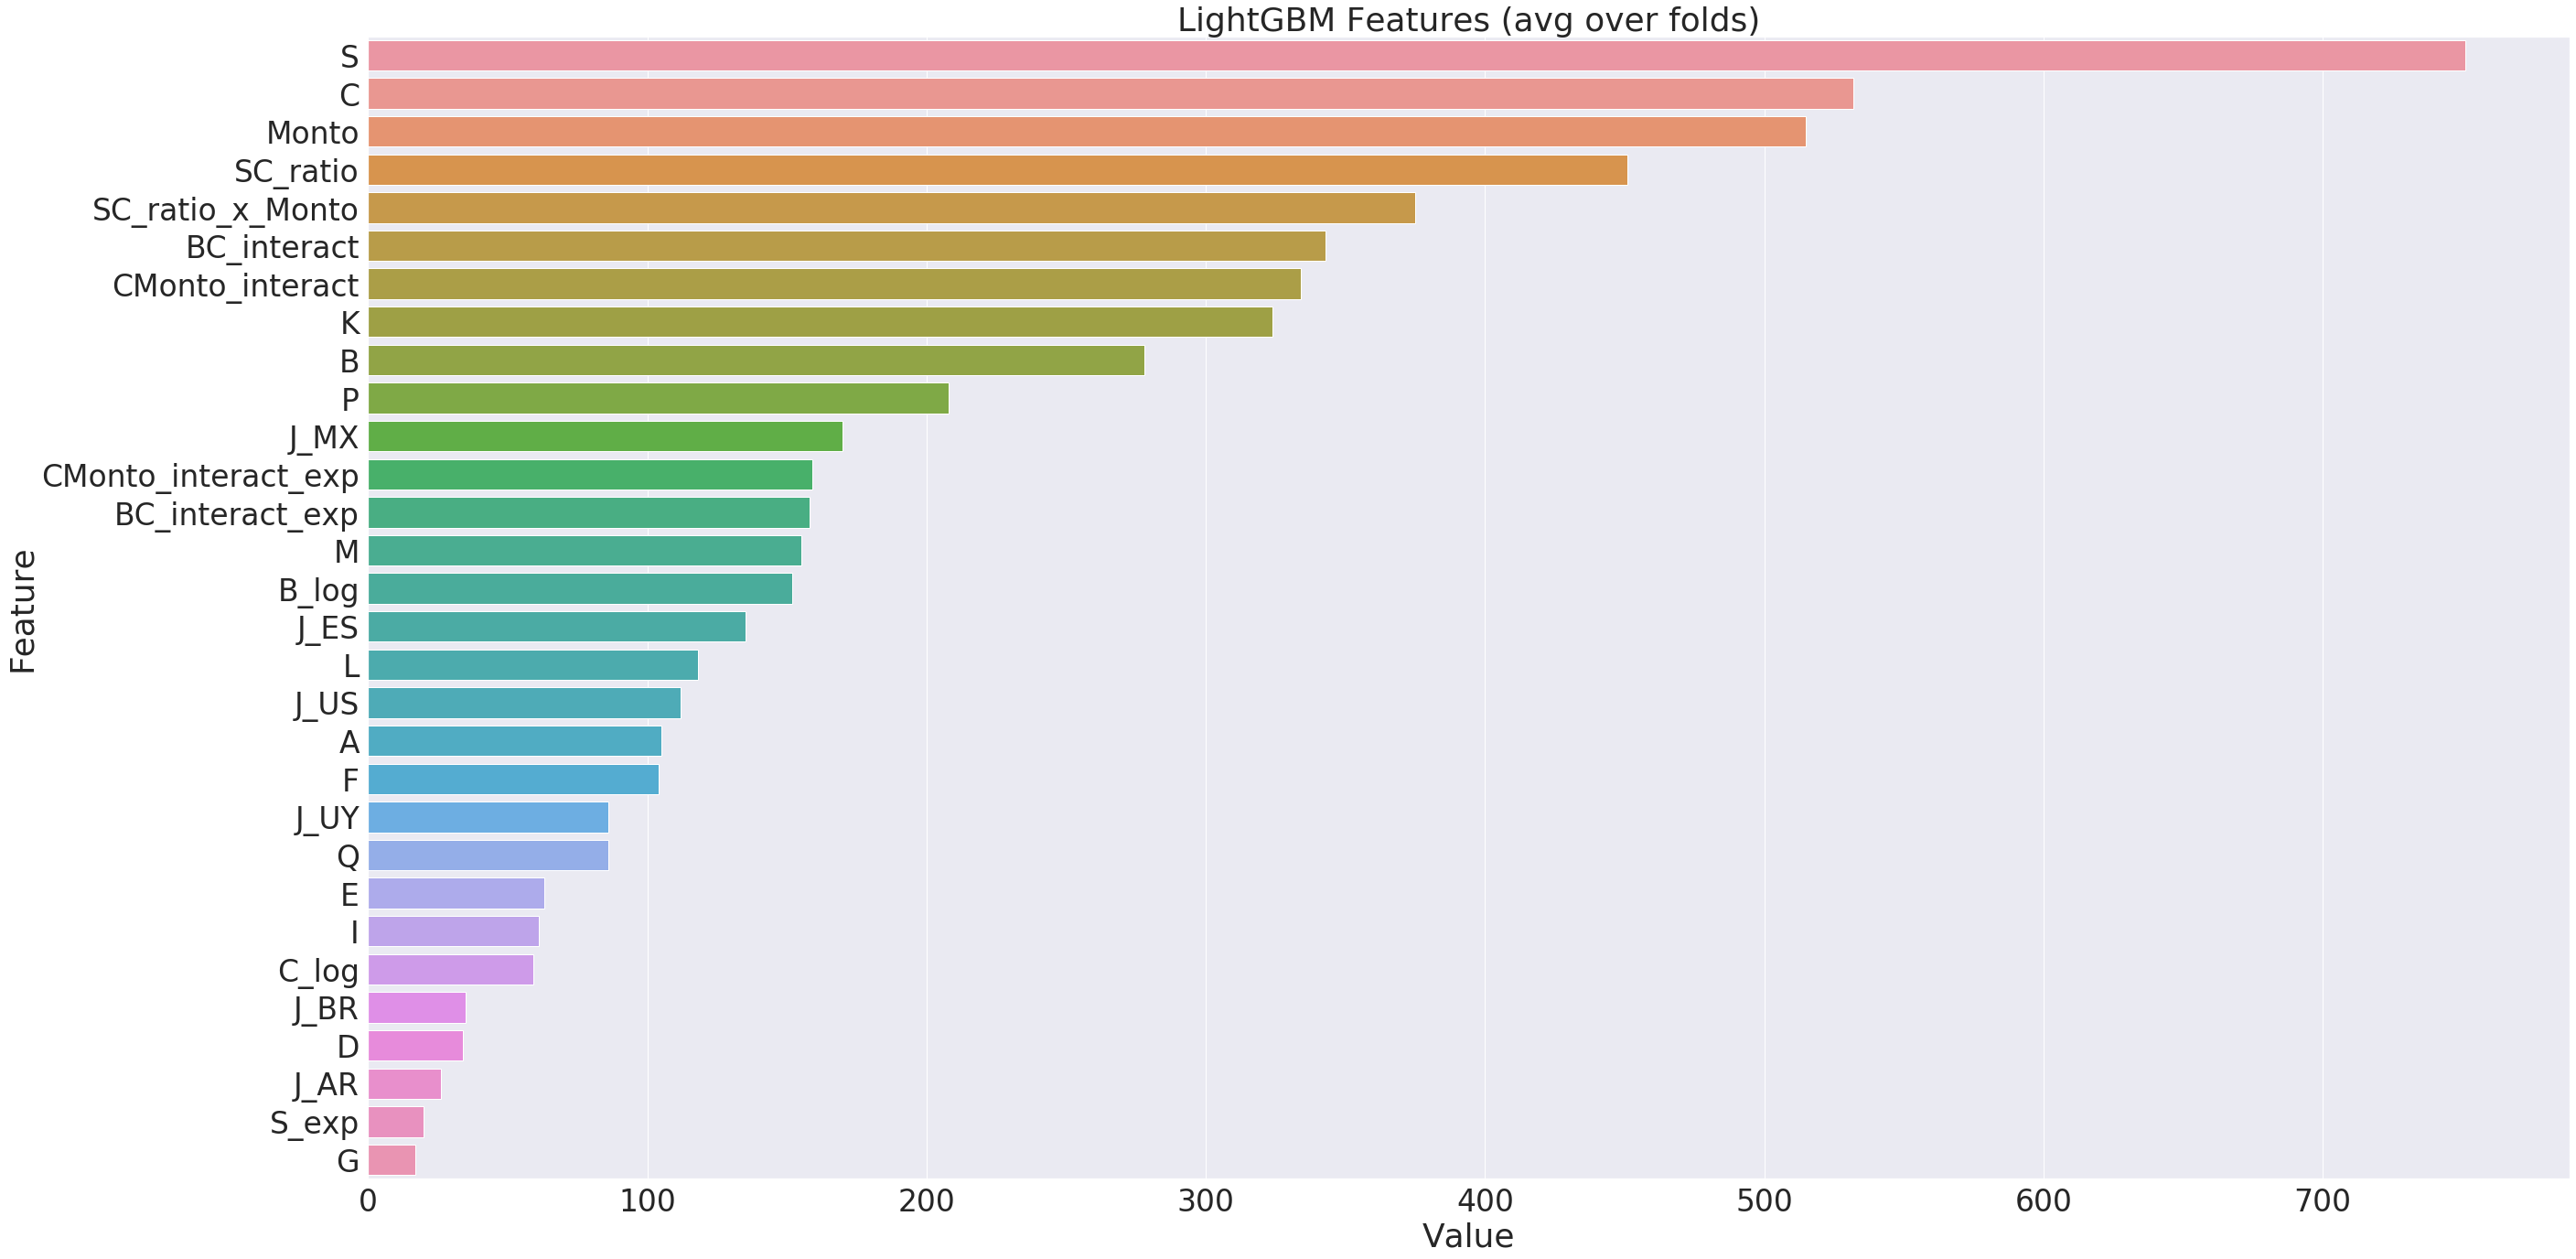

In [29]:
plotImp(classifier , X_train, df.drop('Fraude', axis=1).columns)

### LGBM Test - Ganancia

In [42]:
lgbm_8_test = []
y_prob_test = classifier.predict(X_test)
ypred_test = [1 if x > 0.8 else 0 for x in y_prob_test]
print(custom_loss_calc(y_test.index, y_test, ypred_test))
lgbm_8_test.append(custom_loss_calc(y_test.index, y_test, ypred_test))

61050


### Accuracy del test

In [45]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_test, ypred_test), 4)

0.7703